- only subset ITAN plasmid injected mouse

In [1]:
import os
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

# scRNA-seq analysis pipeline
import scanpy as sc
import pandas as pd
import numpy as np

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import mplscience
%matplotlib inline

# Models & Calculation
import scvi
from scvi import autotune
from ray import tune
import ray
import torch

In [2]:
adata = sc.read_h5ad('../output/annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 53408 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [3]:
adata = adata[adata.obs['cell_type'].isin(['OPC', 'COP', 'Tumor'])]
adata

View of AnnData object with n_obs × n_vars = 27925 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [5]:
adata = adata[adata.obs.sample_id.isin(['Mouse1', 'Mouse2', 'Mouse3', 'Mouse4', 'Control'])].copy()
adata

AnnData object with n_obs × n_vars = 18014 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    obsm: 'X_pca', 'X_scANVI', 'X_scVI', 'X_umap'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

In [ ]:
del adata.layers['log1p']
del adata.obsm

In [8]:
adata.write('../output/annotated_lgg_only.h5ad')

# 1. Re-integrate with scANVI
- run in clooud

In [4]:
import os
import gc
import warnings
warnings.filterwarnings("ignore")

# single cell pipelines
import scanpy as sc
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import mplscience

# scvi-tools
import scvi
import torch

print(scvi.__version__)
sc.logging.print_header()

np.random.seed(777)
torch.manual_seed(777)
scvi.settings.seed = 777

batch_key = 'sample_id'


1.2.1


Seed set to 777


scanpy==1.10.4 anndata==0.11.1 umap==0.5.7 numpy==1.26.3 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 pynndescent==0.5.13


In [6]:
from scvi import autotune
from ray import tune
import ray

In [11]:
adata = sc.read_h5ad('workspace/annotated_lgg_only.h5ad')
adata

AnnData object with n_obs × n_vars = 18014 × 29009
    obs: 'sample_id', 'sample_info', 'age', 'sex', 'barcode', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'scDblFinder_score', 'scDblFinder_class', 'doublet_score', 'predicted_doublet', 'cell_type', 'grade', 'GFP', 'leiden_res1', 'wb_anno', 'wb_conf_score', 'cellid_prediction', 'leiden_res2', 'new_cell_type', 'old_cell_type', 'leiden', 'predicted_labels', 'conf_score', 'each_cell_type'
    uns: 'each_cell_type_colors', 'neighbors', 'sample_info_colors', 'umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [12]:
sc.pp.filter_genes(adata, min_cells = 1)
sc.pp.highly_variable_genes(adata, n_top_genes = 2000, subset = True, layer = 'counts', flavor = 'seurat_v3', batch_key = batch_key) 

In [17]:
scvi.model.SCVI.setup_anndata(adata, layer = 'counts', batch_key = batch_key, continuous_covariate_keys=['pct_counts_mt', 'pct_counts_ribo'])
model_scvi = scvi.model.SCVI(adata, n_layers=2)

In [18]:
model_scvi.train(early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: 1687.781. Signaling Trainer to stop.


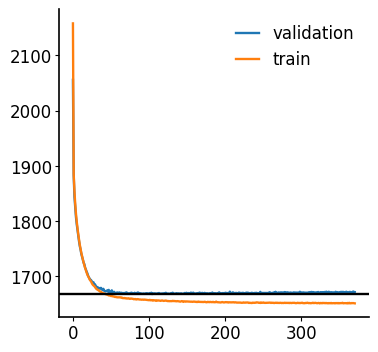

In [19]:
with mplscience.style_context():
    y = model_scvi.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(model_scvi.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(model_scvi.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [20]:
model_scvi.save('/workspace/output/model_scvi_lgg_only')

In [21]:
model_scanvi = scvi.model.SCANVI.from_scvi_model(scvi_model= model_scvi,adata = adata, labels_key = 'cell_type', unlabeled_category='unlabelled')

In [22]:
model_scanvi.train(
    max_epochs=20,
    early_stopping=True,
    early_stopping_monitor="validation_loss",
    early_stopping_patience=10,
    plan_kwargs={
        "lr": 1e-3,           # Reduce learning rate
        "weight_decay": 1e-4, # Add regularization
        "n_epochs_kl_warmup": 5  # Warm-up for stability
    }
)

INFO     Training for 20 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Monitored metric validation_loss did not improve in the last 10 records. Best score: 1699.709. Signaling Trainer to stop.


In [23]:
model_scanvi.save('/workspace/output/model_scanvi_subcluster')

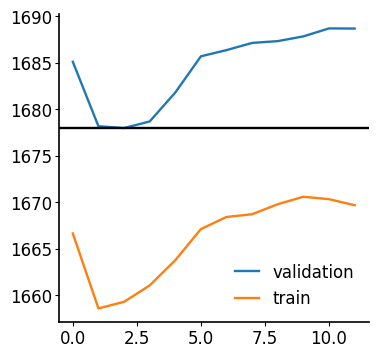

In [25]:
import matplotlib.pyplot as plt
import mplscience
with mplscience.style_context():
    y = model_scanvi.history['reconstruction_loss_validation']['reconstruction_loss_validation'].min()
    plt.plot(model_scanvi.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label = 'validation')
    plt.plot(model_scanvi.history['reconstruction_loss_train']['reconstruction_loss_train'], label = 'train')

    plt.axhline(y, c = 'k')
    plt.legend()
    plt.show()

In [26]:
adata = sc.read_h5ad('workspace/annotated_lgg_only.h5ad')
adata.obsm['X_scVI'] = model_scvi.get_latent_representation()
adata.obsm['X_scANVI'] = model_scanvi.get_latent_representation()

In [27]:
sc.pp.neighbors(adata, use_rep='X_scANVI')
sc.tl.umap(adata)

In [28]:
adata.write('/workspace/output/annotated_lgg_only_embedding.h5ad')